In [8]:
!pip install pydub
!pip install librosa

In [9]:
!apt-get update
!apt-get install -y ffmpeg
!pip install pydub
!pip install librosa matplotlib

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 3,917 B in 2s (1,870 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (

In [12]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    print(f"'{filename}' has been uploaded")

Saving 095522039.m4a to 095522039.m4a
'095522039.m4a' has been uploaded


In [13]:
from pydub import AudioSegment
import librosa
import numpy as np

# 1. Set the file name (must match the name of the uploaded file)
m4a_file = '095522039.m4a'

# 2. Load the m4a file
audio = AudioSegment.from_file(m4a_file, format='m4a')

# 3. Convert raw audio data to a numpy array
y = np.array(audio.get_array_of_samples()).astype(np.float32)
sr = audio.frame_rate

# 4. Convert stereo to mono (if necessary)
if audio.channels == 2:
    y = y.reshape((-1, 2))
    y = np.mean(y, axis=1)

# 5. Normalize the amplitude
y /= np.max(np.abs(y))

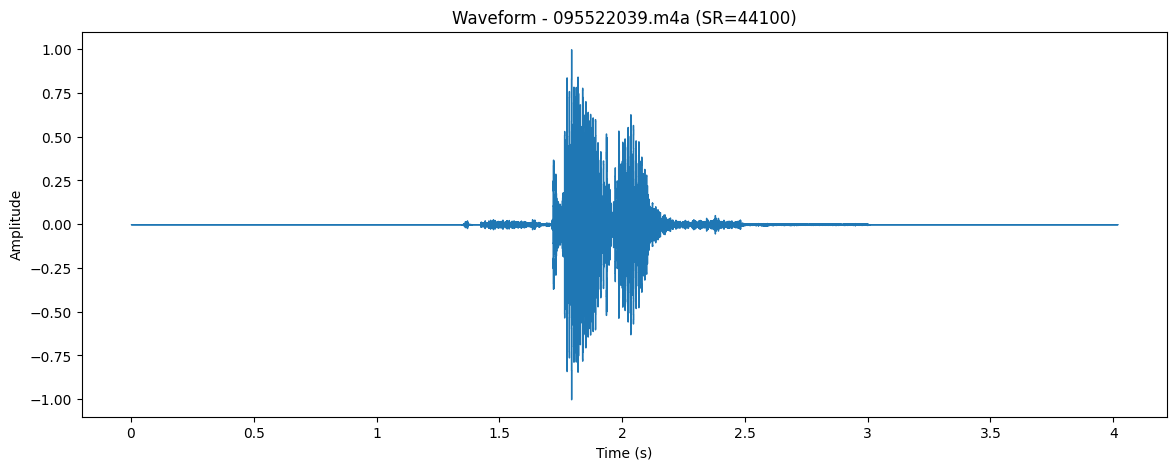

In [16]:
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title(f'Waveform - {m4a_file} (SR={sr})') # 여기를 수정합니다.
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

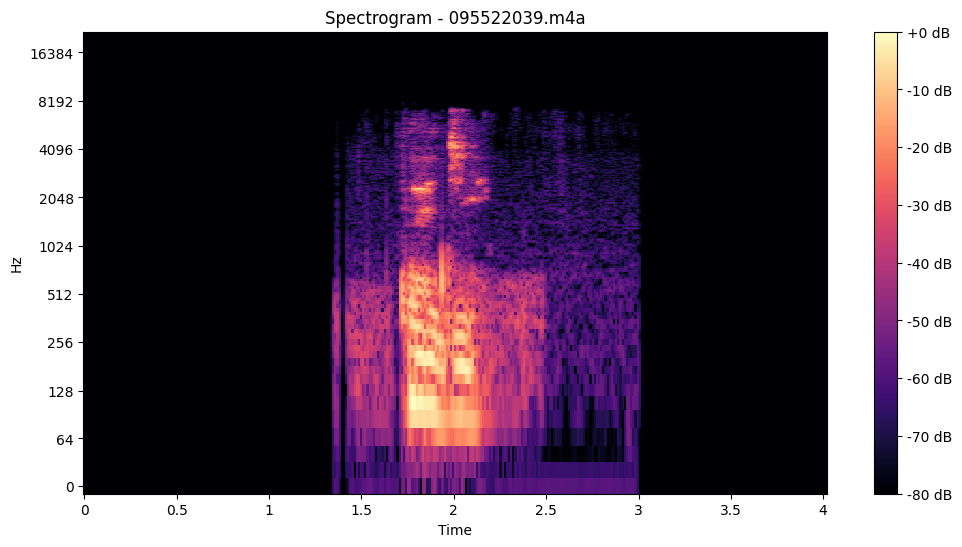

In [23]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

m4a_file = '095522039.m4a'

D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram - {m4a_file}')
plt.show()

In [24]:
!pip install torchaudio

In [29]:
import torch
import torchaudio
import librosa
import numpy as np

# Convert the original audio data to a PyTorch tensor
audio_tensor = torch.from_numpy(y)
orig_sr = sr  # 44100 Hz

# Step 1: Downsample from 44100 Hz to 8000 Hz
down_sr_to_8k = 8000
resampler_down_8k = torchaudio.transforms.Resample(orig_sr, down_sr_to_8k)
downsampled_8k = resampler_down_8k(audio_tensor)

print(f"Original audio shape: {audio_tensor.shape}, Sample Rate: {orig_sr} Hz")
print(f"Downsampled (to 8k) shape: {downsampled_8k.shape}, Sample Rate: {down_sr_to_8k} Hz")

# Step 2: Upsample from 8000 Hz to 16000 Hz
up_sr_to_16k = 16000
resampler_up_16k = torchaudio.transforms.Resample(down_sr_to_8k, up_sr_to_16k)
upsampled_16k = resampler_up_16k(downsampled_8k)

print(f"Upsampled (to 16k) shape: {upsampled_16k.shape}, Sample Rate: {up_sr_to_16k} Hz")

Original audio shape: torch.Size([177152]), Sample Rate: 44100 Hz
Downsampled (to 8k) shape: torch.Size([32137]), Sample Rate: 8000 Hz
Upsampled (to 16k) shape: torch.Size([64274]), Sample Rate: 16000 Hz


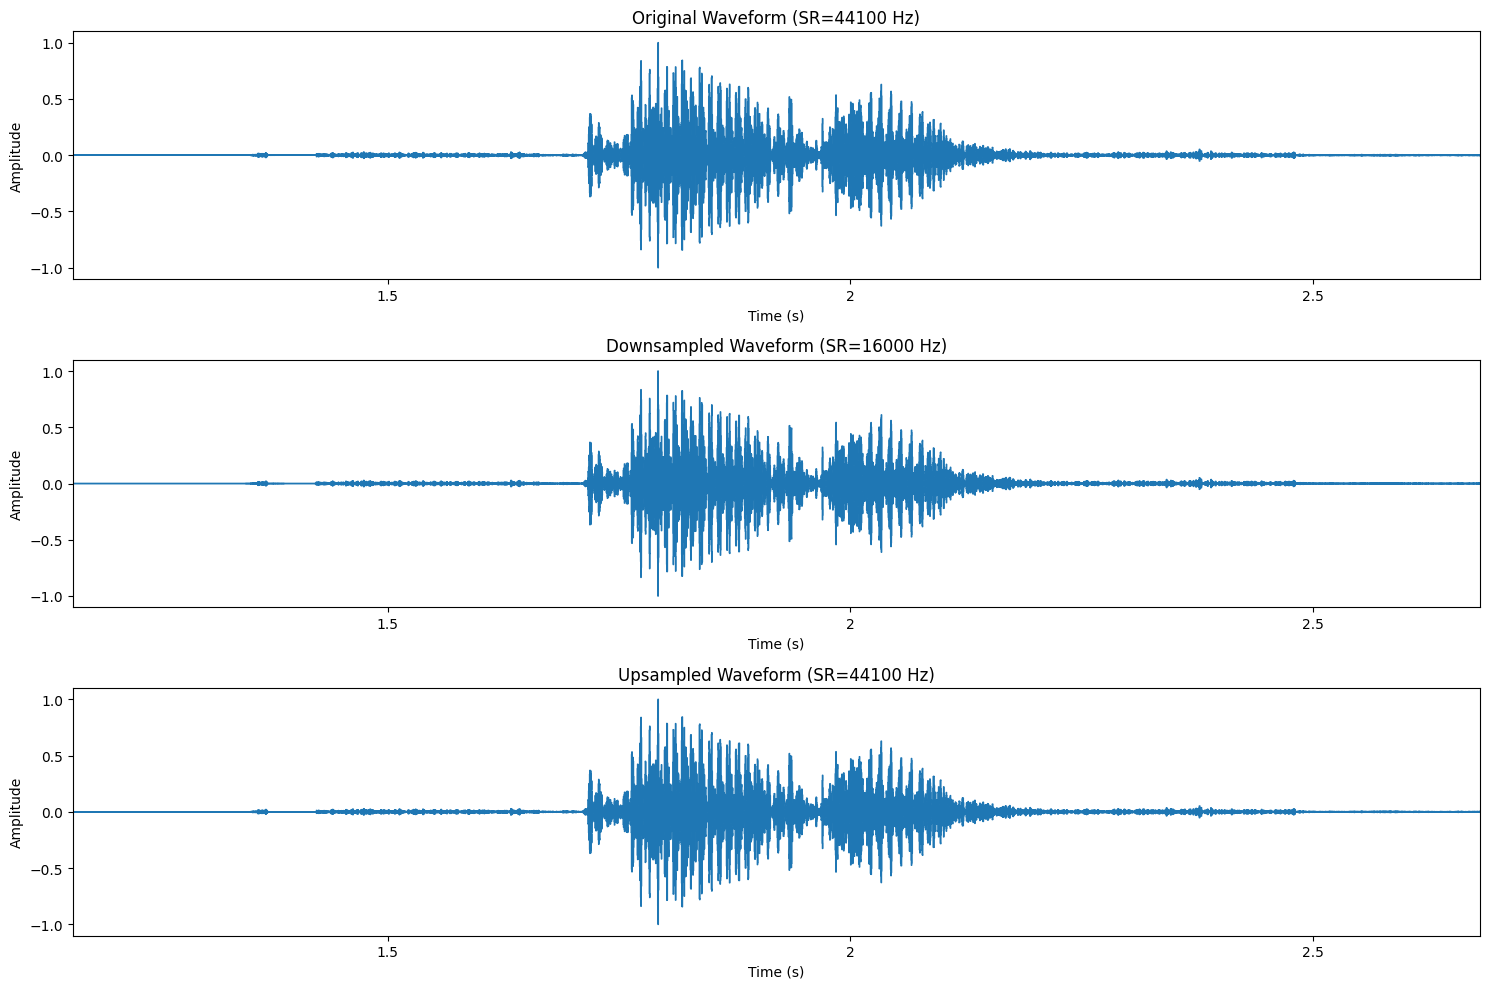

In [32]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

# Convert the PyTorch tensors back to NumPy arrays
y_downsampled = downsampled_audio.squeeze().numpy()
y_upsampled = upsampled_audio.squeeze().numpy()

# Find the start and end of the non-silent audio
start_sample = np.where(np.abs(y) > 0.01)[0][0]
end_sample = np.where(np.abs(y) > 0.01)[0][-1]

# Convert sample indices to time in seconds
start_time = librosa.samples_to_time(start_sample, sr=orig_sr)
end_time = librosa.samples_to_time(end_sample, sr=orig_sr)

# Add a small buffer to the start and end times
buffer = 0.2
start_time = max(0, start_time - buffer)
end_time = end_time + buffer

plt.figure(figsize=(15, 10))

# Plot Original Waveform with adjusted range
plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=orig_sr)
plt.title(f'Original Waveform (SR={orig_sr} Hz)')
plt.xlim(start_time, end_time)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot Downsampled Waveform with adjusted range
plt.subplot(3, 1, 2)
librosa.display.waveshow(y_downsampled, sr=down_sr)
plt.title(f'Downsampled Waveform (SR={down_sr} Hz)')
plt.xlim(start_time, end_time)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot Upsampled Waveform with adjusted range
plt.subplot(3, 1, 3)
librosa.display.waveshow(y_upsampled, sr=up_sr)
plt.title(f'Upsampled Waveform (SR={up_sr} Hz)')
plt.xlim(start_time, end_time)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

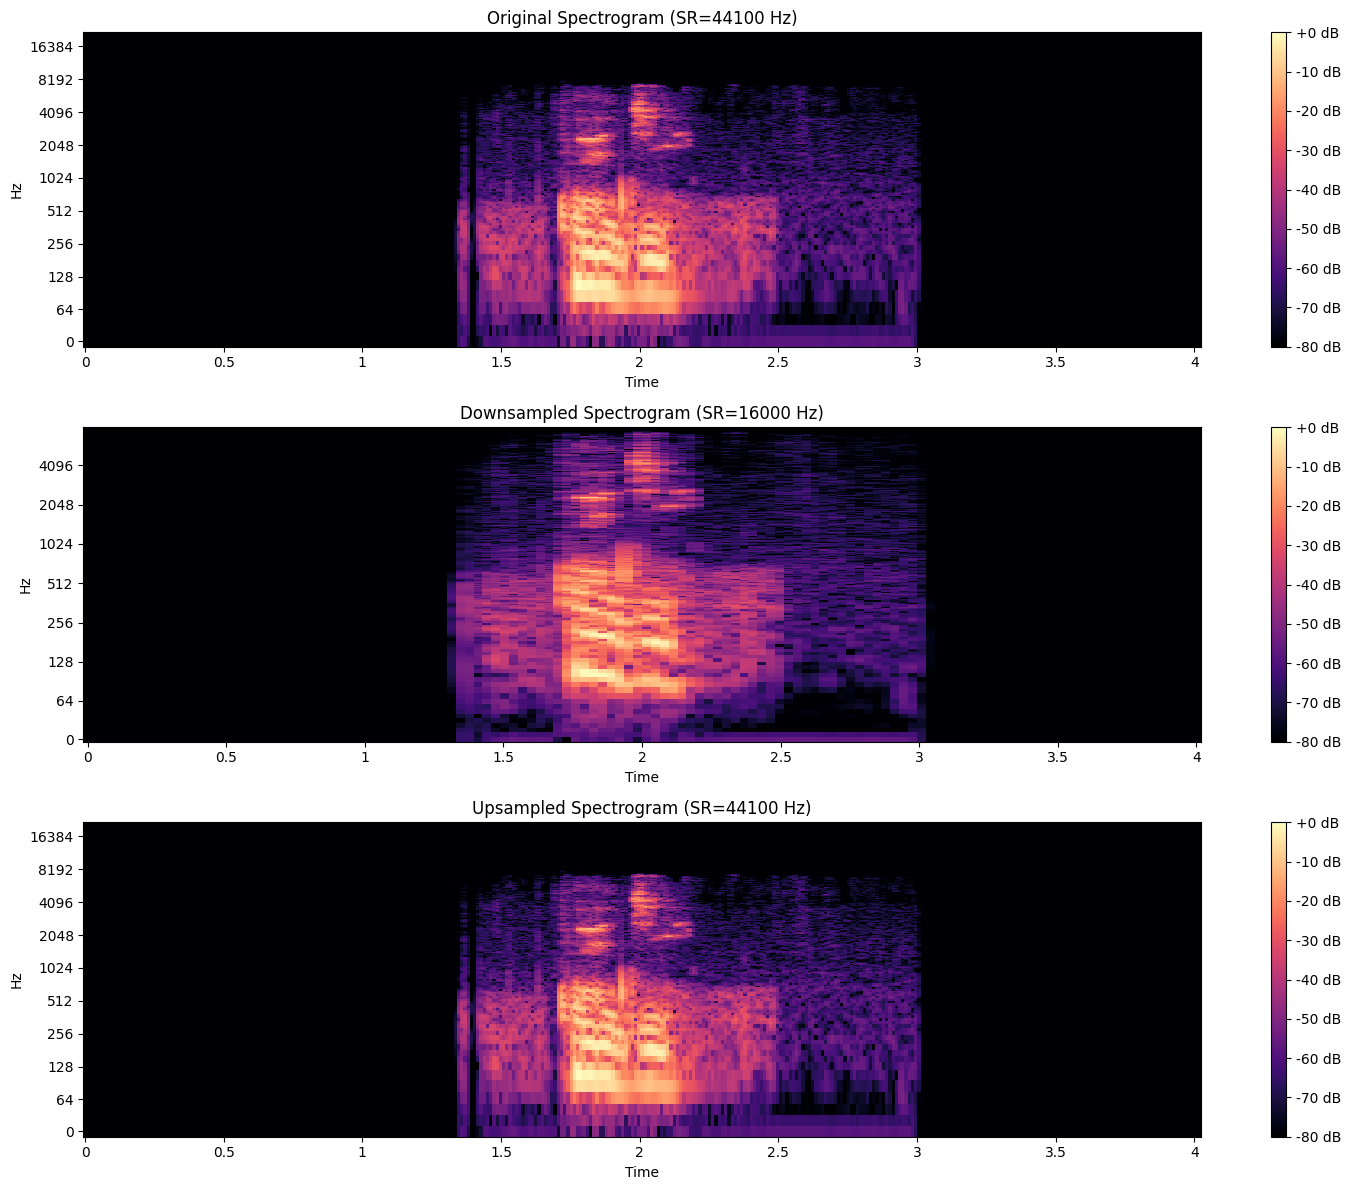

In [37]:
plt.figure(figsize=(15, 12))

# Spectrogram of Original Audio
plt.subplot(3, 1, 1)
D_orig = librosa.stft(y)
S_db_orig = librosa.amplitude_to_db(np.abs(D_orig), ref=np.max)
librosa.display.specshow(S_db_orig, sr=orig_sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Original Spectrogram (SR={orig_sr} Hz)')

# Spectrogram of Downsampled Audio
plt.subplot(3, 1, 2)
D_down = librosa.stft(y_downsampled)
S_db_down = librosa.amplitude_to_db(np.abs(D_down), ref=np.max)
librosa.display.specshow(S_db_down, sr=down_sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Downsampled Spectrogram (SR={down_sr} Hz)')

# Spectrogram of Upsampled Audio
plt.subplot(3, 1, 3)
D_up = librosa.stft(y_upsampled)
S_db_up = librosa.amplitude_to_db(np.abs(D_up), ref=np.max)
librosa.display.specshow(S_db_up, sr=up_sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Upsampled Spectrogram (SR={up_sr} Hz)')

plt.tight_layout()
plt.show()

In [33]:
import os
import torchaudio

file_to_find = "095522039.m4a"
found_path = None


for root, dirs, files in os.walk("/"):
    if file_to_find in files:
        found_path = os.path.join(root, file_to_find)
        break

if found_path:
    print(f"파일을 찾았습니다. 정확한 경로: {found_path}")
    try:
        waveform, sample_rate = torchaudio.load(found_path)
        print(f"파일이 성공적으로 로드되었습니다!")
        print(f"Sample rate: {sample_rate} Hz")
        print(f"Waveform shape: {waveform.shape}")
    except Exception as e:
        print(f"오류: 파일을 로드하는 중 문제가 발생했습니다. ({e})")
else:
    print(f"오류: '{file_to_find}' 파일을 찾을 수 없습니다.")
    print("파일이 올바르게 업로드되었는지 다시 확인해주세요.")

파일을 찾았습니다. 정확한 경로: /095522039.m4a
파일이 성공적으로 로드되었습니다!
Sample rate: 44100 Hz
Waveform shape: torch.Size([1, 177152])


In [48]:
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as T
import torch
import os

# 1. Load the Audio File
# Assuming the file is in the /content directory, a common location in Google Colab.
file_name = "095522039.m4a"
file_path = os.path.join("/content", file_name)

# Check if the file exists before trying to load it
if not os.path.exists(file_path):
    print(f"Error: The file does not exist at {file_path}. Please make sure it is uploaded.")
else:
    waveform, sample_rate = torchaudio.load(file_path)
    print("File loaded successfully!")
    print(f"Sample rate: {sample_rate} Hz")
    print(f"Waveform shape: {waveform.shape}")

    # 2. Define Feature Extraction Transforms
    n_mels = 128
    n_mfcc = 40
    n_lfcc = 40
    n_fft = 400
    hop_length = 200

    mel_spectrogram_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )

    mfcc_transform = T.MFCC(
        sample_rate=sample_rate,
        n_mfcc=n_mfcc,
        melkwargs={"n_fft": n_fft, "hop_length": hop_length, "n_mels": n_mels}
    )

    lfcc_transform = T.LFCC(
        sample_rate=sample_rate,
        n_lfcc=n_lfcc,
        speckwargs={"n_fft": n_fft, "win_length": n_fft, "hop_length": hop_length}
    )

    # 3. Extract Features
    mel_spectrogram = mel_spectrogram_transform(waveform)
    mfcc = mfcc_transform(waveform)
    lfcc = lfcc_transform(waveform)

    # Get the Mel Filter Bank from the MelSpectrogram transform
    mel_filter_bank = mel_spectrogram_transform.mel_scale.fb
    print(f"Mel Filter Bank shape: {mel_filter_bank.shape}")

    # 4. Visualize All Features
    fig, axes = plt.subplots(4, 1, figsize=(12, 18))
    fig.suptitle("Feature Extraction Results for 095522039.m4a", fontsize=16)

    # Corrected dB transformation
    db_transform = T.AmplitudeToDB()

    # Visualize Mel-Spectrogram
    axes[0].imshow(db_transform(mel_spectrogram).numpy()[0], cmap='inferno', origin='lower', aspect='auto')
    axes[0].set_title("1. Mel-Spectrogram")
    axes[0].set_xlabel("Time Frame")
    axes[0].set_ylabel("Mel Frequency Bin")

    # Visualize MFCCs
    axes[1].imshow(mfcc.numpy()[0], cmap='viridis', origin='lower', aspect='auto')
    axes[1].set_title("2. MFCCs")
    axes[1].set_xlabel("Time Frame")
    axes[1].set_ylabel("MFCC Coefficient")

    # Visualize LFCCs
    axes[2].imshow(lfcc.numpy()[0], cmap='plasma', origin='lower', aspect='auto')
    axes[2].set_title("3. LFCCs")
    axes[2].set_xlabel("Time Frame")
    axes[2].set_ylabel("LFCC Coefficient")

    # Visualize Mel Filter Bank
    axes[3].imshow(mel_filter_bank.numpy(), cmap='gray', origin='lower', aspect='auto')
    axes[3].set_title("4. Mel Filter Bank")
    axes[3].set_xlabel("Frequency Bin")
    axes[3].set_ylabel("Mel Frequency Bin")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Error: The file does not exist at /content/095522039.m4a. Please make sure it is uploaded.


In [47]:
import torchaudio


audio_source = "복사한 경로를 여기에 붙여넣으세요"

try:
    waveform, sample_rate = torchaudio.load(audio_source)
    print("성공: 파일이 로드되었습니다!")
    print(f"Sample rate: {sample_rate} Hz")
    print(f"Waveform shape: {waveform.shape}")

except Exception as e:
    print(f"오류: 파일을 로드할 수 없습니다. 소스를 다시 확인해주세요. ({e})")

오류: 파일을 로드할 수 없습니다. 소스를 다시 확인해주세요. (Failed to open the input "복사한 경로를 여기에 붙여넣으세요" (No such file or directory).)


In [22]:
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as T
import torch

# 1. Load the Audio File
# Use the path that you successfully found earlier.
file_path = "/095522039.m4a"
waveform, sample_rate = torchaudio.load(file_path)

# 2. Define the Feature Extraction Transforms
n_mels = 128
n_mfcc = 40
n_lfcc = 40
n_fft = 400
hop_length = 200

mel_spectrogram_transform = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={"n_fft": n_fft, "hop_length": hop_length, "n_mels": n_mels}
)

lfcc_transform = T.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={"n_fft": n_fft, "win_length": n_fft, "hop_length": hop_length}
)

# 3. Extract the Features
mel_spectrogram = mel_spectrogram_transform(waveform)
mfcc = mfcc_transform(waveform)
lfcc = lfcc_transform(waveform)

# The Mel Filter Bank is not a separate transform; it's a component.
# We can get it from the MelSpectrogram transform for visualization.
mel_filter_bank = mel_spectrogram_transform.mel_scale.fb
print(f"Mel Filter Bank shape: {mel_filter_bank.shape}")

# 4. Visualize All Features
fig, axes = plt.subplots(4, 1, figsize=(12, 18))
fig.suptitle("Feature Extraction Results for 095522039.m4a", fontsize=16)

# Visualize Mel-Spectrogram
axes[0].imshow(torchaudio.functional.amplitude_to_db(mel_spectrogram).numpy()[0], cmap='inferno', origin='lower', aspect='auto')
axes[0].set_title("Mel-Spectrogram")
axes[0].set_xlabel("Time Frame")
axes[0].set_ylabel("Mel Frequency Bin")

# Visualize MFCCs
axes[1].imshow(mfcc.numpy()[0], cmap='viridis', origin='lower', aspect='auto')
axes[1].set_title("MFCCs")
axes[1].set_xlabel("Time Frame")
axes[1].set_ylabel("MFCC Coefficient")

# Visualize LFCCs
axes[2].imshow(lfcc.numpy()[0], cmap='plasma', origin='lower', aspect='auto')
axes[2].set_title("LFCCs")
axes[2].set_xlabel("Time Frame")
axes[2].set_ylabel("LFCC Coefficient")

# Visualize Mel Filter Bank
axes[3].imshow(mel_filter_bank.numpy(), cmap='gray', origin='lower', aspect='auto')
axes[3].set_title("Mel Filter Bank")
axes[3].set_xlabel("Frequency Bin")
axes[3].set_ylabel("Mel Frequency Bin")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

RuntimeError: Failed to open the input "/095522039.m4a" (No such file or directory).

In [8]:
import torchaudio

file_path = "/095522040.m4a"

waveform, sample_rate = torchaudio.load(file_path)
print(f"Sample rate: {sample_rate} Hz")
print(f"Waveform shape: {waveform.shape}")

Sample rate: 44100 Hz
Waveform shape: torch.Size([1, 177152])


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

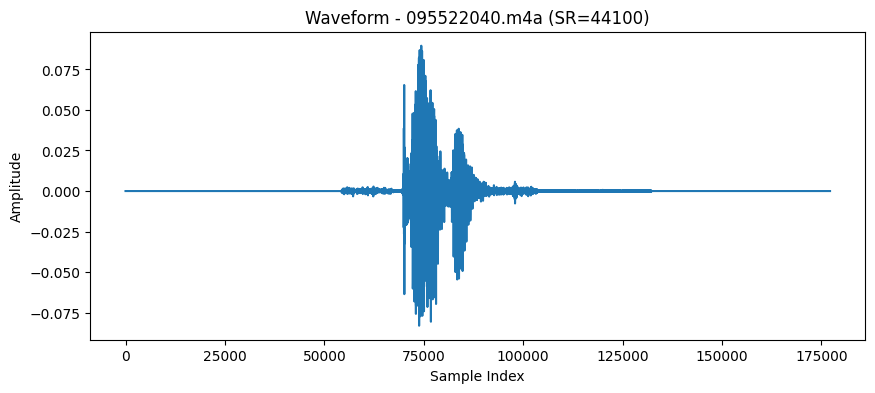

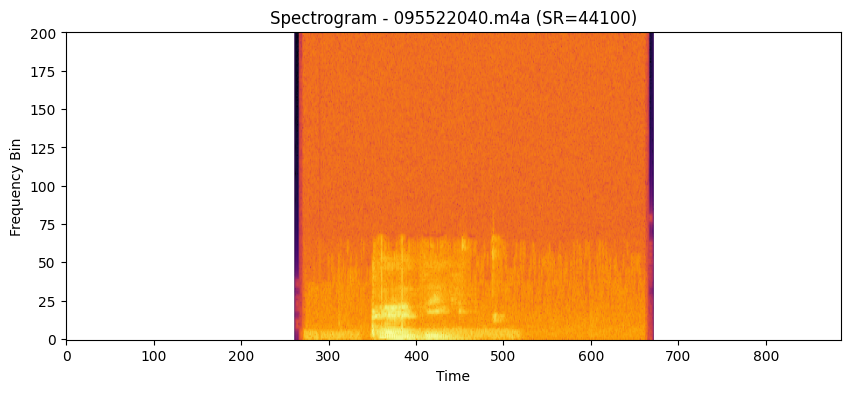

In [15]:
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as T


file_name = "095522040.m4a"

# Visualize Waveform
plt.figure(figsize=(10, 4))
plt.plot(waveform.t().numpy())
plt.title(f"Waveform - {file_name} (SR={sample_rate})")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

# Visualize Spectrogram
spectrogram_transform = T.Spectrogram(n_fft=400, win_length=400, hop_length=200)
spectrogram = spectrogram_transform(waveform)

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram.log2()[0, :, :].numpy(), cmap='inferno', origin='lower', aspect='auto')
plt.title(f"Spectrogram - {file_name} (SR={sample_rate})")
plt.xlabel("Time")
plt.ylabel("Frequency Bin")
plt.show()

In [16]:
new_sample_rate = sample_rate // 2
resampler = T.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
downsampled_waveform = resampler(waveform)

upsampled_sample_rate = sample_rate * 2
upsampler = T.Resample(orig_freq=sample_rate, new_freq=upsampled_sample_rate)
upsampled_waveform = upsampler(waveform)

print(f"Downsampled waveform shape: {downsampled_waveform.shape}")
print(f"Upsampled waveform shape: {upsampled_waveform.shape}")

Downsampled waveform shape: torch.Size([1, 88576])
Upsampled waveform shape: torch.Size([1, 354304])


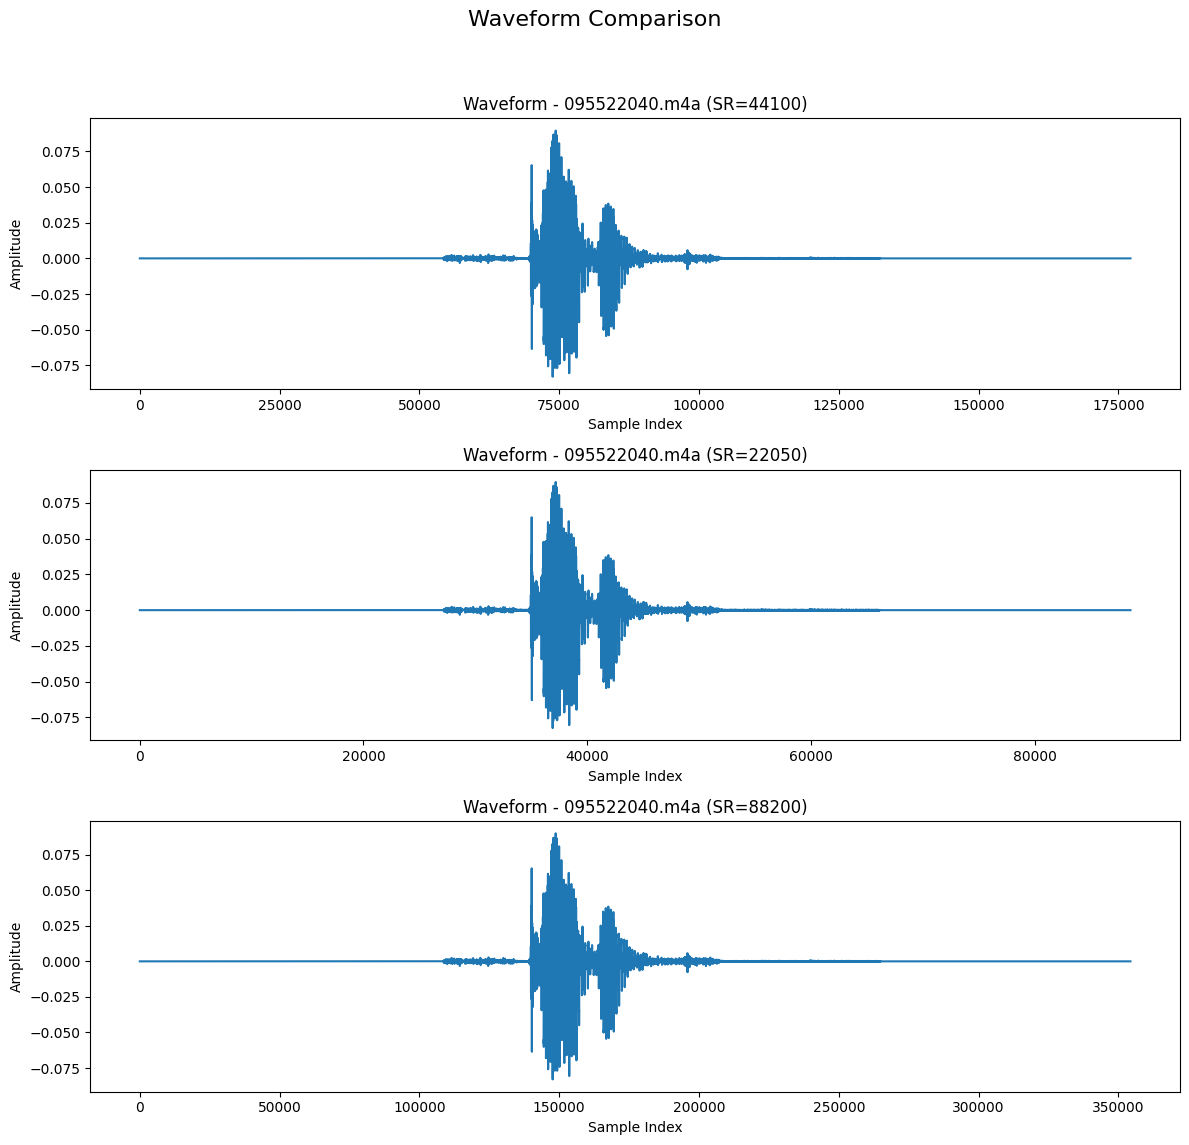

In [20]:
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as T
import torch

file_name = "095522040.m4a"

# Resampling (다운샘플링 & 업샘플링)
new_sample_rate_down = sample_rate // 2
resampler_down = T.Resample(orig_freq=sample_rate, new_freq=new_sample_rate_down)
downsampled_waveform = resampler_down(waveform)

new_sample_rate_up = sample_rate * 2
resampler_up = T.Resample(orig_freq=sample_rate, new_freq=new_sample_rate_up)
upsampled_waveform = resampler_up(waveform)

fig, axes = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle("Waveform Comparison", fontsize=16)

axes[0].plot(waveform.t().numpy())
axes[0].set_title(f"Waveform - {file_name} (SR={sample_rate})")
axes[0].set_xlabel("Sample Index")
axes[0].set_ylabel("Amplitude")

axes[1].plot(downsampled_waveform.t().numpy())
axes[1].set_title(f"Waveform - {file_name} (SR={new_sample_rate_down})")
axes[1].set_xlabel("Sample Index")
axes[1].set_ylabel("Amplitude")

axes[2].plot(upsampled_waveform.t().numpy())
axes[2].set_title(f"Waveform - {file_name} (SR={new_sample_rate_up})")
axes[2].set_xlabel("Sample Index")
axes[2].set_ylabel("Amplitude")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

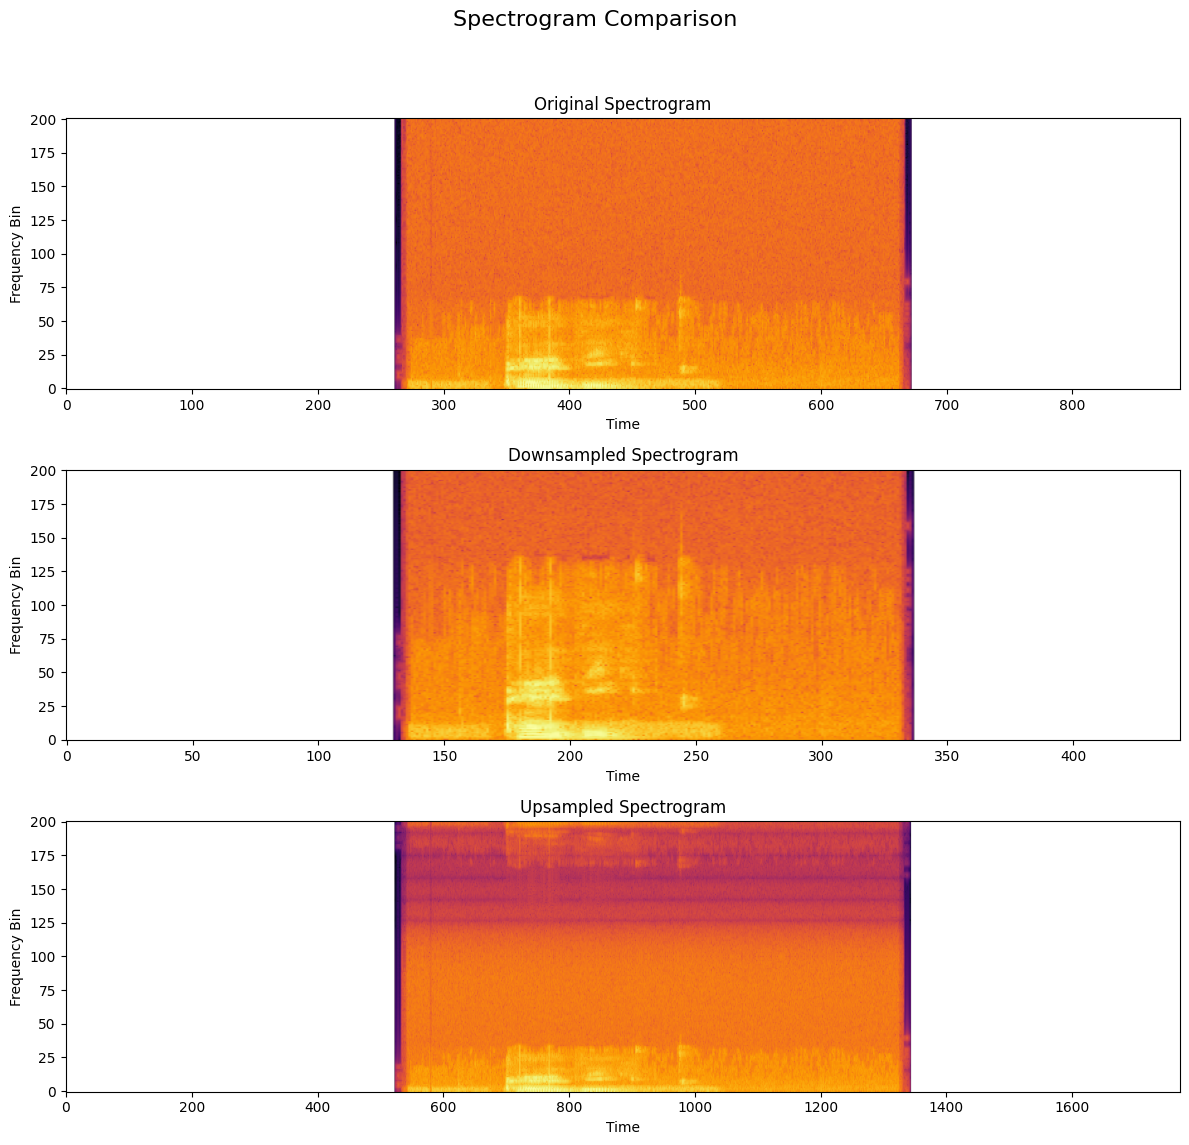

In [21]:
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as T
import torch


# 1. Transform to Spectrograms
spectrogram_transform = T.Spectrogram(n_fft=400, win_length=400, hop_length=200)
original_spectrogram = spectrogram_transform(waveform)
downsampled_spectrogram = spectrogram_transform(downsampled_waveform)
upsampled_spectrogram = spectrogram_transform(upsampled_waveform)

# 2. Visualize All Spectrograms
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle("Spectrogram Comparison", fontsize=16)

# Original Spectrogram
axes[0].imshow(original_spectrogram.log2()[0, :, :].numpy(), cmap='inferno', origin='lower', aspect='auto')
axes[0].set_title("Original Spectrogram")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Frequency Bin")

# Downsampled Spectrogram
axes[1].imshow(downsampled_spectrogram.log2()[0, :, :].numpy(), cmap='inferno', origin='lower', aspect='auto')
axes[1].set_title("Downsampled Spectrogram")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Frequency Bin")

# Upsampled Spectrogram
axes[2].imshow(upsampled_spectrogram.log2()[0, :, :].numpy(), cmap='inferno', origin='lower', aspect='auto')
axes[2].set_title("Upsampled Spectrogram")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Frequency Bin")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()